In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import LogLocator
from matplotlib import colors
import numpy as np
import time
import scipy.signal as ss
import scipy
from scipy.optimize import curve_fit
from scipy import optimize, signal


import marvin
from marvin.tools import Maps, Cube
from marvin import config
from marvin.tools import RSS
import marvin.utils.plot.map as mapplot

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FLRW
from astropy import units as u

import photutils
from photutils import geometry


config.setRelease('DR17')
marvin.config.mode = 'remote'
marvin.config.download = True
#plt.style.use('seaborn') ####### Oder lieber einen anderen Stil?
fsize = 18

data_marco = fits.open('2kpc_aperture_AGN_catalog.fits')
data_table = Table.read(data_marco, hdu=1)

hdul = fits.open('data\MASCOT.fits')

cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)

manga_id=  hdul[1].data['MaNGA ID']
manga_id_list = list(manga_id)

manga_id_list.remove('8138-12703') # Ausnahmefall!

from datetime import datetime

current_dateTime = datetime.now()
today = str(current_dateTime.day)+'.'+str(current_dateTime.month)+'.'+str(current_dateTime.year)

print(today)

# Ich empfehle beim einfachen Durchgehen das Ausschalten der Warunungen 
import warnings
warnings.filterwarnings('ignore')

import sys

def processBar(total, progress, barlength=40):
    barlength, status = barlength, ""
    progress = float(progress) / float(total)
    if progress >= 1:
        progress, status = 1, "\r\n"
    block = int(round(barlength * progress))
    text = "\r[{}] {:.0f}% {}".format("#" * block + 
                                      "-" * (barlength - block),
                                      round(progress * 100, 0), status)
    sys.stdout.write(text)
    sys.stdout.flush()
    

26.1.2023


In [3]:
def sector_binning(r, phi, r_min=0, r_max=np.inf, phi_min=0, phi_max=360):
    """generate sector binning by elliptical coordinate
    
    Args:
        r: the radius matrix
        phi: the pich angle of the matrix
        r_min, r_max: the range of selected radius
        phi_min, phi_max: the range of selected phi in degree
    Returns:
        return the selecting ndarray with selected region with True value
    """
    return ((r < r_max) & (r >= r_min)) & ((phi < phi_max) & (phi >= phi_min))

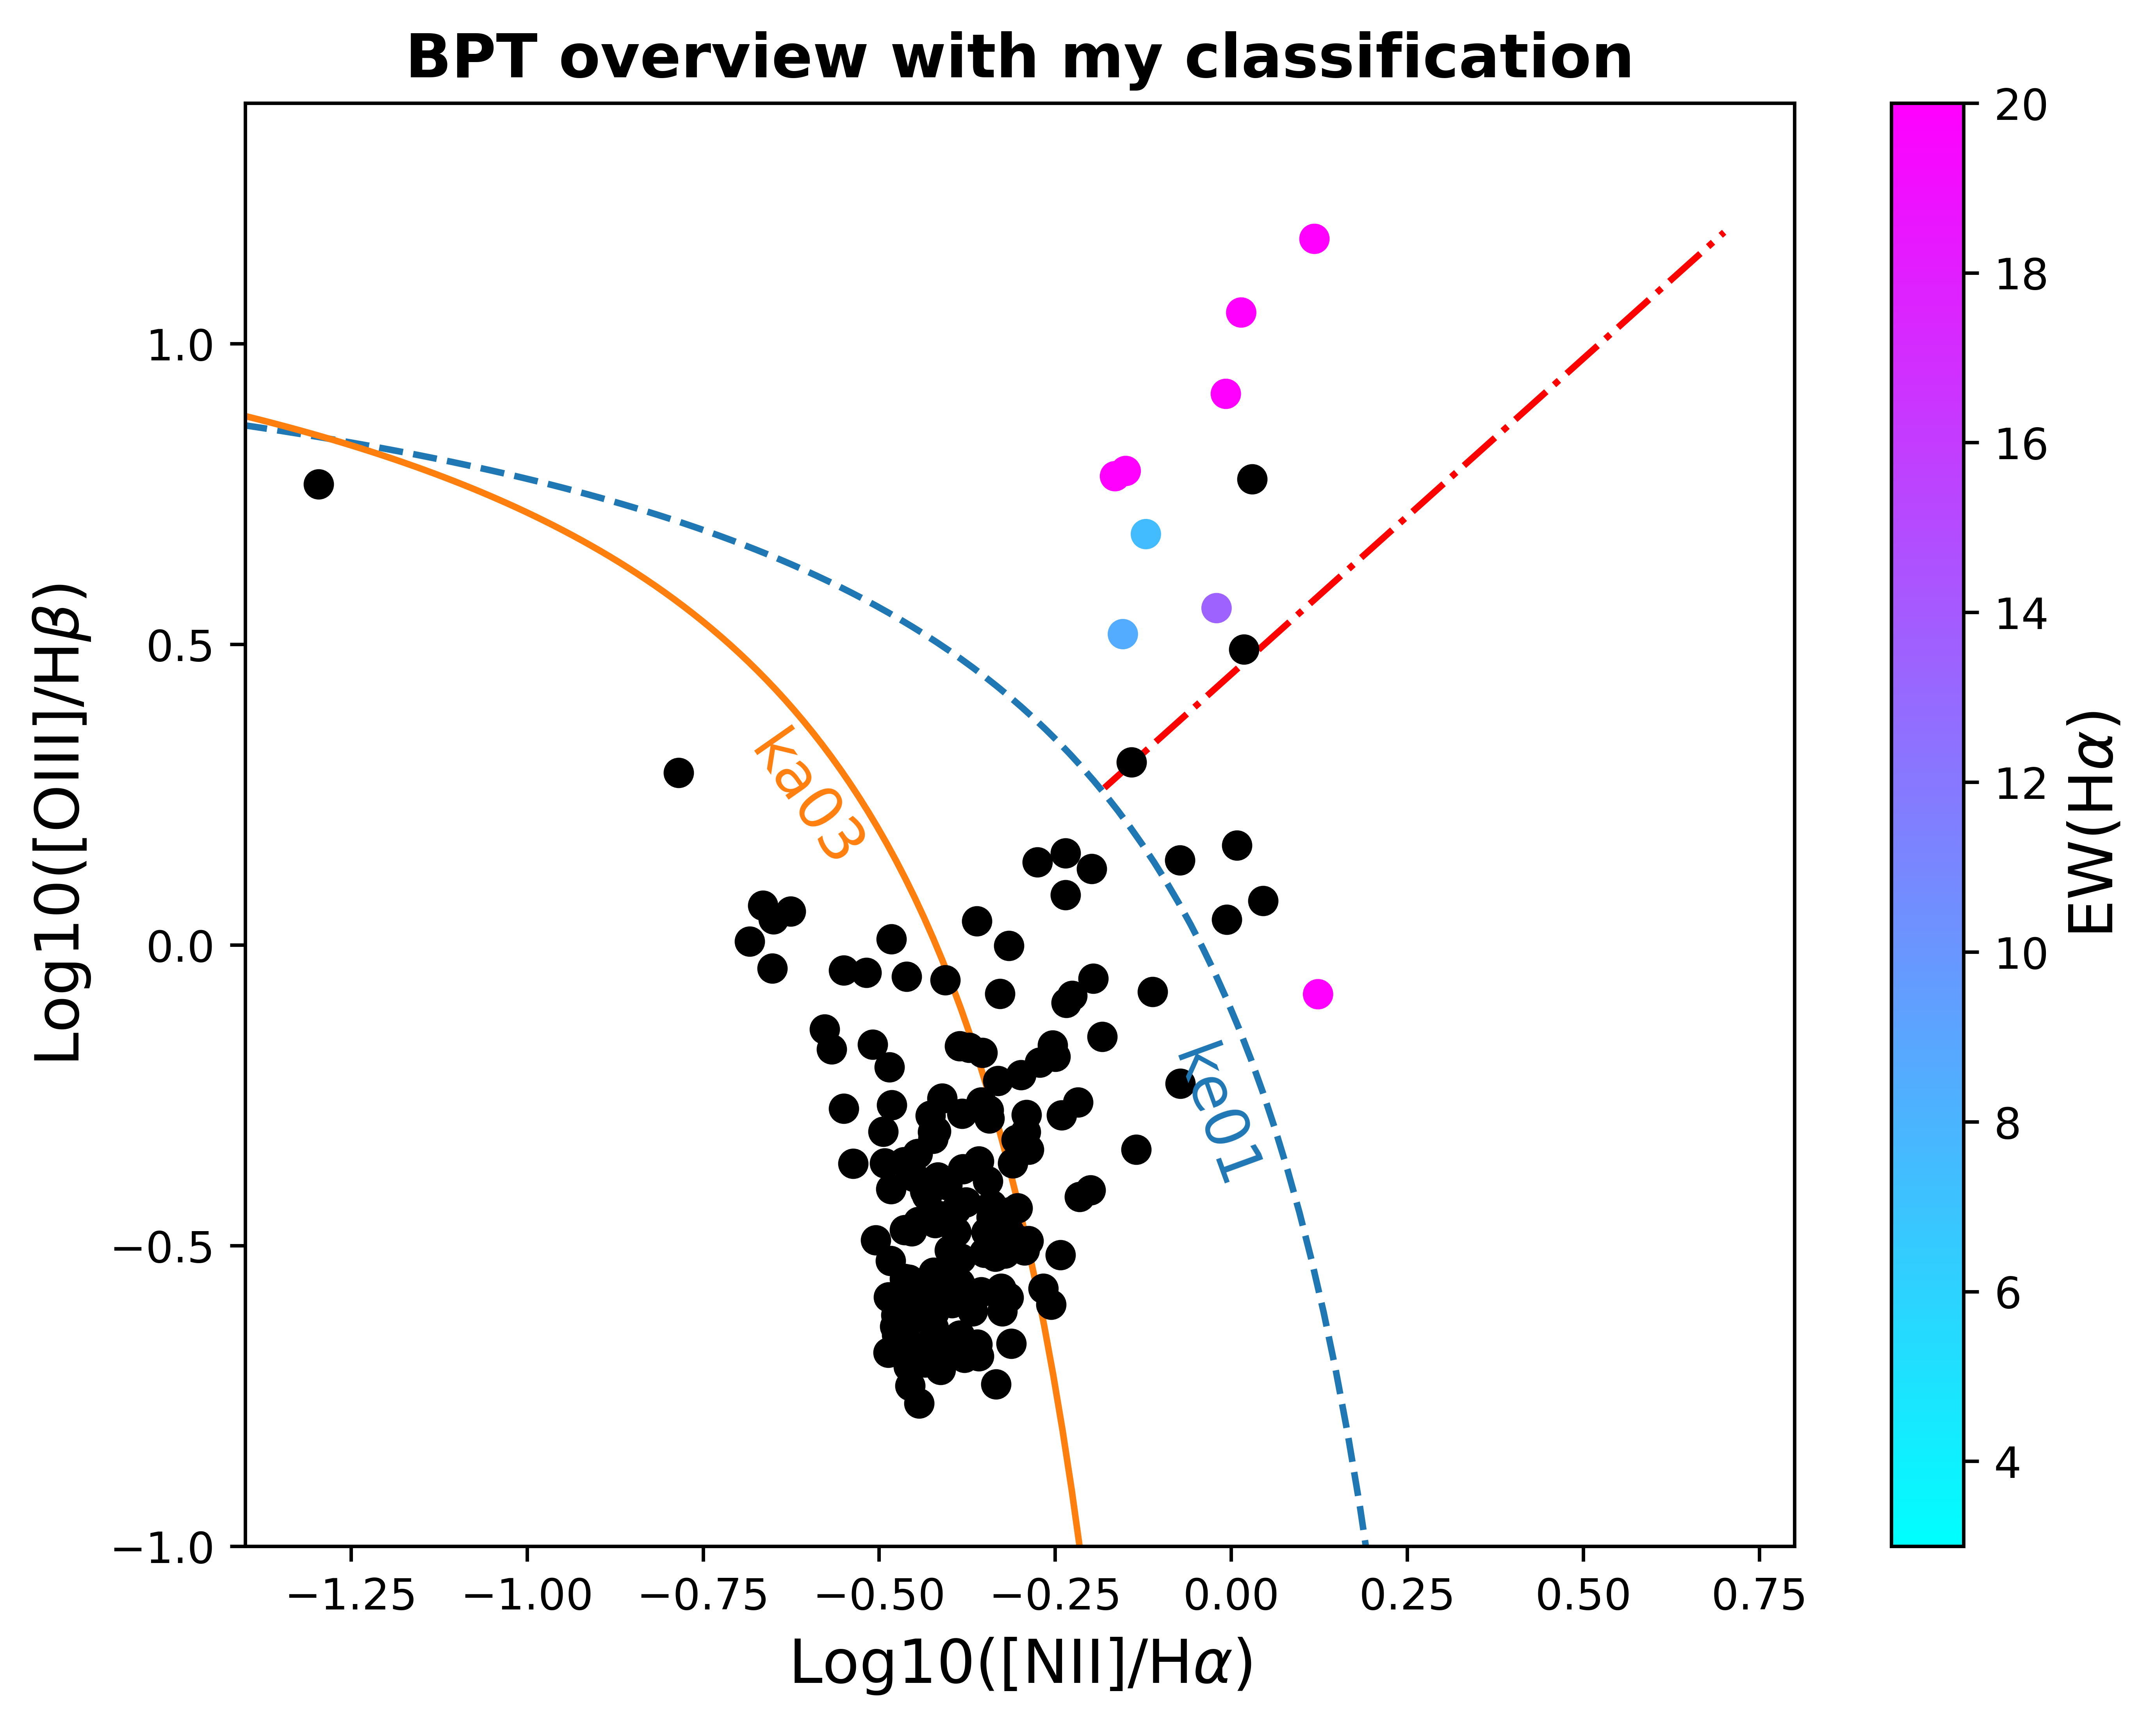

In [7]:
# Plot all the sample in the BPT diagram
# History:
#   2018-10-04: add the history
#   2018-04-26: the submitted AGN data
#

# set for background PPT
plt.style.use('default')

f_agn = Table.read('data/AGNs-2022-12-12.dat', format='ascii')
f_exclude = Table.read('data/AGNs-exclude-2022-12-12.dat', format='ascii')
#exclude_binary = (f_agn['is_binary'] == '0')

fig = plt.figure(figsize=(8, 6), dpi = 800)

# plot the line
x1 = np.linspace(-1.5, 0.2, 100)
ke01 = 0.61/(x1-0.47)+1.19
x2 = np.linspace(-1.5, -.2, 100)
ka03 = 0.61/(x2-0.05)+1.3
x3 = np.linspace(-0.18, 0.7, 100)
schawinski_line = 1.05*x3+0.45
plt.plot(x1, ke01, '--', color='C0') 
plt.text(-0.7, 0.13, 'ka03', rotation=-55, fontsize=14, color='C1')
plt.plot(x2, ka03, 'C1') 
plt.text(-0.1, -0.4, 'ke01', rotation=-70, fontsize=14, color='C0')
plt.plot(x3, schawinski_line, 'r-.')

# first plot all the non-AGN galaxies as background
subfig1 = plt.plot(f_exclude['BPT_x'], f_exclude['BPT_y'], 'ko', label='DR15', alpha=1)

# plot all the AGNs with colorbar show it's EW(Ha)['7991-6104','9499-6104','8720-1901']
select = np.where((f_agn['plateifu'] != '7991-6104') & (f_agn['plateifu'] != '9499-6104') & (f_agn['plateifu'] != '8720-1901'))

subfig2 = plt.scatter(f_agn[select]['BPT_x'], 
                      f_agn[select]['BPT_y'], c=f_agn[select]['EW_Ha'], label="AGN",cmap='cool', vmin=3, vmax=20)

cbar = fig.colorbar(subfig2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(r'EW(H$\alpha$)', fontsize=14)

plt.xlim((-1.4, 0.8))
plt.ylim((-1., 1.4))
plt.xlabel(r'Log10([NII]/H$\alpha)$', fontsize=14)
plt.ylabel(r'Log10([OIII]/H$\beta)$', fontsize=14)
plt.title(r'BPT overview with my classification', weight='bold', fontsize=14)
plt.show()

# save figure to file
fig.savefig("./results/all_sample_without_composite.png", bbox_inches='tight')

In [4]:
data_table

MANGAID,AGN,SEYFERT,LINER,STAR_FORM,Composite,Ambiguous,OIII/Hb,NII/Ha,SII/Ha,OI/Ha,EW_Ha
str13,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64
10001-12701,False,False,False,True,False,False,-0.02993398141971023,-0.37003620889556826,-0.5640511424938514,-1.3152033836785124,22.252226772092612
10001-12702,False,False,False,False,True,False,-0.1763664468317557,-0.22709277305307696,-0.29708851014451576,-0.6306949965085539,5.028469227012908
10001-12703,False,False,False,True,False,False,-0.339373727394249,-0.5622802206364972,-0.4095816038708885,-1.311969230370984,9.170439187485478
10001-12704,False,False,False,True,False,False,-0.18668100625359535,-0.3455422849302795,-0.4110319569907883,-1.1453118457086138,12.00124139746519
10001-12705,False,False,False,True,False,False,-0.6831613021691779,-0.6026929545836409,-0.45776888198088783,-1.627746245692862,19.641654509766322
10001-1901,False,False,False,False,True,False,-0.3372024087056674,-0.3135013384006937,-0.27353482919503874,-1.242852500475038,13.146858896792718
10001-1902,False,False,False,False,False,False,0.027991489557954063,--,--,--,--
10001-3701,False,False,False,False,False,False,--,--,--,--,--
10001-3702,False,False,False,True,False,False,-0.5597814259338122,-0.46022103135786163,-0.33877225379383263,-1.8657405821430875,40.50633601720557


In [6]:
ewha = []
x_agn = []
y_agn = []
y_non_agn = []
x_non_agn = []
agn_marco_list = []

for plateifu in manga_id_list:
    if np.bool( data_table [np.where(data_table['MANGAID'] == plateifu)] ['AGN']):
        x_agn.append(np.float(data_table [np.where(data_table['MANGAID'] == plateifu)] ['NII/Ha']))
        y_agn.append(np.float(data_table [np.where(data_table['MANGAID'] == plateifu)] ['OIII/Hb']))
        ewha.append(np.float(data_table [np.where(data_table['MANGAID'] == plateifu)] ['EW_Ha']))
        agn_marco_list.append(plateifu)
    else:
        x_non_agn.append(np.float(data_table [np.where(data_table['MANGAID'] == plateifu)] ['NII/Ha']))
        y_non_agn.append(np.float(data_table [np.where(data_table['MANGAID'] == plateifu)] ['OIII/Hb']))
        continue
        
ewha = np.array(ewha)
x_agn = np.array(x_agn)
y_agn = np.array(y_agn)
y_non_agn = np.array(y_non_agn)
x_non_agn = np.array(x_non_agn)
        
#print(x_agn, '\n', y_agn, '\n', x_non_agn, '\n', y_non_agn, '\n')

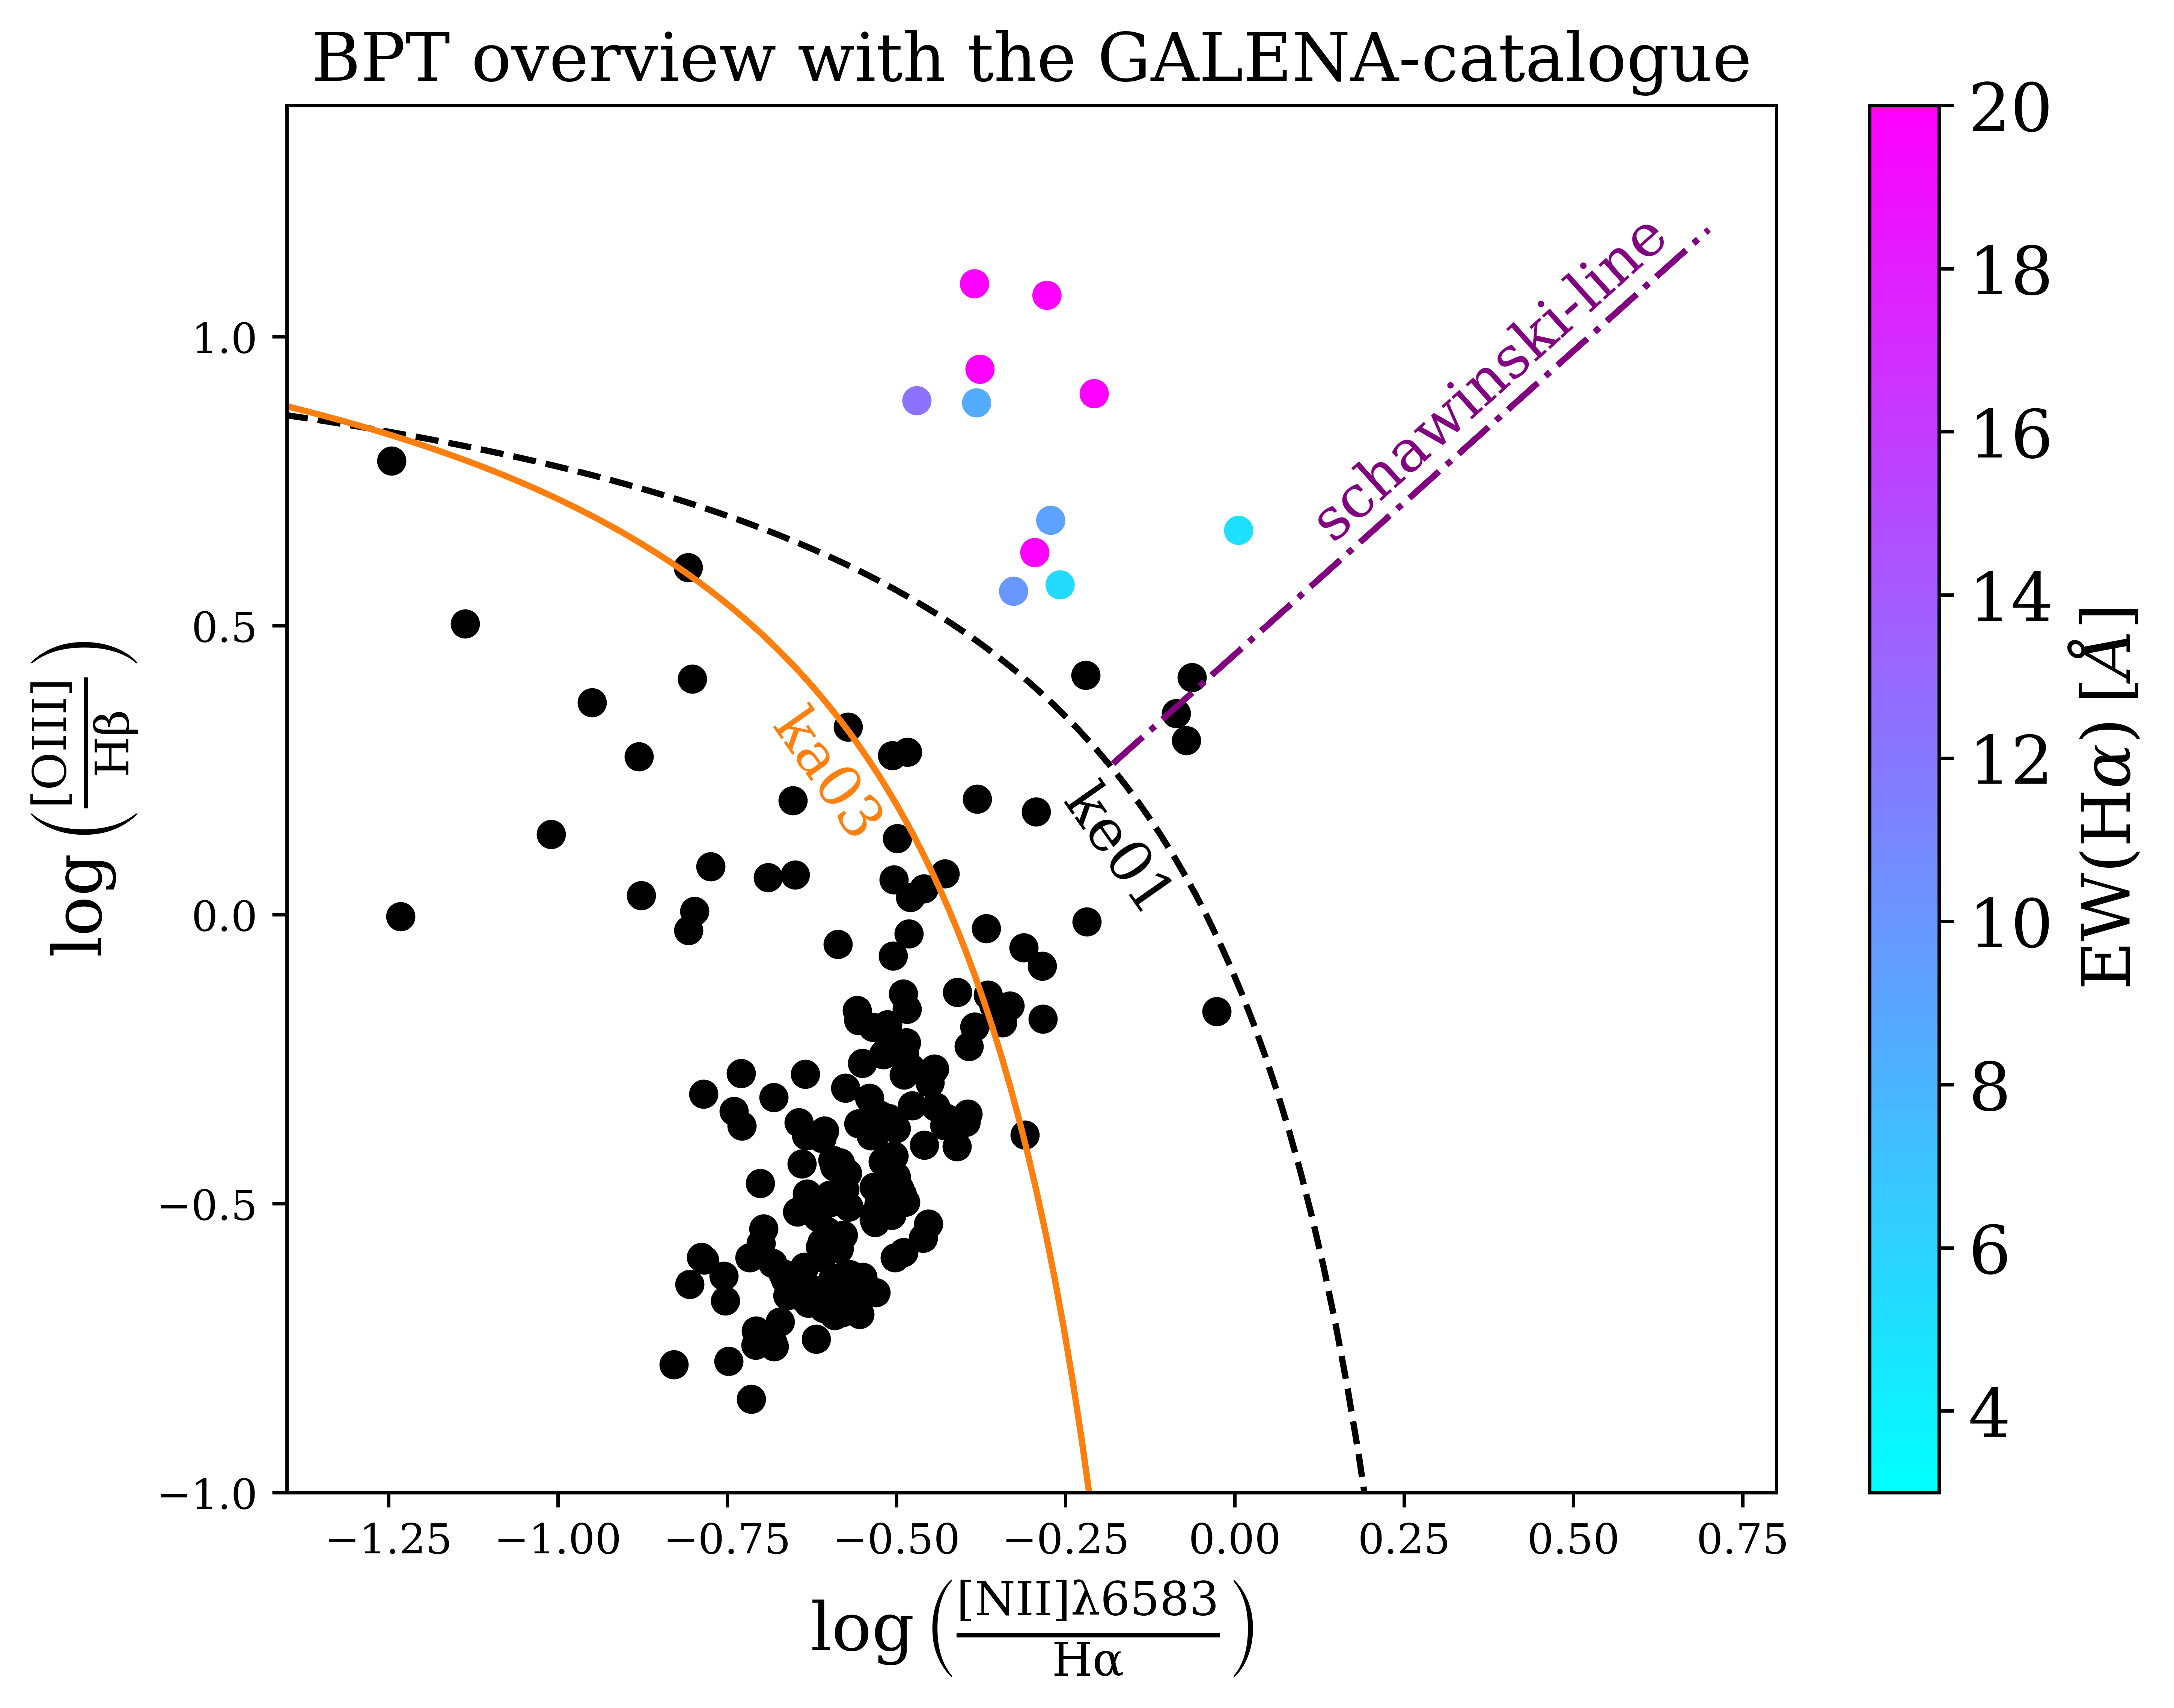

In [16]:
fig = plt.figure(figsize=(8, 6), dpi = 800)
fs = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
# plot the line
x1 = np.linspace(-1.5, 0.2, 100)
ke01 = 0.61/(x1-0.47)+1.19
x2 = np.linspace(-1.5, -.2, 100)
ka03 = 0.61/(x2-0.05)+1.3
x3 = np.linspace(-0.18, 0.7, 100)
schawinski_line = 1.05*x3+0.45
plt.plot(x1, ke01, '--', color='k') 
plt.text(-0.7, 0.13, 'ka03', rotation=-55, fontsize=14, color='C1')
plt.plot(x2, ka03, 'C1') 
plt.text(-0.27, -0, 'ke01', rotation=-55, fontsize=14, color='Black')
plt.plot(x3, schawinski_line, linestyle='-.', color='purple')
plt.text(0.1, 0.65, 'schawinski-line', rotation=42, fontsize=14, color='purple')

subfig1 = plt.scatter(x_non_agn, y_non_agn, color = 'black', marker ='o', label='DR15', alpha=1)
subfig2 = plt.scatter(x_agn, y_agn, c=ewha, label="AGN",cmap='cool', vmin=3, vmax=20)

cbar = fig.colorbar(subfig2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'EW(H$\alpha) \: [\AA]$', fontsize=fs)

plt.xlim((-1.4, 0.8))
plt.ylim((-1., 1.4))
plt.xlabel(r'$\rm \log \left( \frac{[NII]\lambda 6583}{H\alpha} \right)$', fontsize=fs)
plt.ylabel(r'$\rm \log \left( \frac{[OIII]}{H\beta} \right)$', fontsize=fs)
plt.title(r'BPT overview with the GALENA-catalogue', fontsize=fs)
plt.savefig('BPT_overview_galena.png')

plt.show()

# save figure to file
#fig.savefig("./results/all_sample_without_composite.png", bbox_inches='tight')

In [10]:
marco_but_not_me = []
me_but_not_marco = []

for plateifu in agn_marco_list:
    if plateifu not in f_agn['plateifu']:
        marco_but_not_me.append(plateifu)
        
for plateifu in f_agn['plateifu']:
    if plateifu not in agn_marco_list:
        me_but_not_marco.append(plateifu)
        
print('Marco has the following AGN classified that I am missing:'  , marco_but_not_me,
      '\nI have the following AGN classified that Marco is missing', me_but_not_marco)

Marco has the following AGN classified that I am missing: ['8979-6102', '9047-6104', '9487-3702'] 
I have the following AGN classified that Marco is missing ['9000-1901']


# Lets look closer at this AGN

In [29]:
def BPT_Plot_OIII(id):
    levels = [3]

    maps = Maps(id)
    ha   = maps['emline_gflux_ha_6564']
    hb   = maps['emline_gflux_hb_4862']
    oiii = maps['emline_gflux_oiii_5008']
    nii  = maps['emline_gflux_nii_6585']
    
    ha [ha.snr < 5] = 0
    hb [hb.snr < 5] = 0
    oiii [oiii.snr < 5] = 0
    nii [nii.snr < 5] = 0   
    
    ha_map = ha.value

    log_oiii_hb = np.log10(oiii.value / hb.value)
    log_nii_ha = np.log10(nii.value / ha.value) 
    
    fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(24,8))
    x1 = np.linspace(-1.5, 0.46, 100)
    x2 = np.linspace(-1.5, 0.09, 100)
    x3 = np.linspace(-0.18, 1, 100)

    def ke01(x):
            return(0.61/(x-0.47)+1.19)
    def ka03(x):
        return(0.61/(x-0.1)+1.3)    
    def schawinski_line(x):
        return(1.05*x+0.45)

    inv_bool  = np.ones(ha.shape, dtype='bool')
    agn_bool  = np.zeros(ha.shape, dtype='bool') 
    sf_bool   = np.zeros(ha.shape, dtype='bool')
    comp_bool = np.zeros(ha.shape, dtype='bool')
    agn_bool_extra = np.zeros(ha.shape, dtype='bool')

    inv_bool  [np.where(np.isnan(log_oiii_hb))] = False
    inv_bool  [np.where(np.isnan(log_nii_ha))] = False
    inv_bool  [np.where(np.isfinite(log_oiii_hb) == False)] = False
    inv_bool  [np.where(np.isfinite(log_nii_ha) == False)] = False

    agn_bool  [np.where((log_oiii_hb >=  ke01(log_nii_ha)) & inv_bool) and np.where((log_nii_ha > 0.47) & inv_bool)] = True
    agn_bool  [np.where((log_oiii_hb >=  ke01(log_nii_ha)) & inv_bool)] = True
    comp_bool [np.where((log_oiii_hb >=  ka03(log_nii_ha)) & (log_oiii_hb <=  ke01(log_nii_ha)) & inv_bool
                     & (log_nii_ha <= 0.47))] = True
    comp_bool [np.where((log_oiii_hb <=  ke01(log_nii_ha)) & (0.47 >= log_nii_ha) &
                        ( log_nii_ha >= 0.1) & inv_bool)] = True
    sf_bool   [np.where((log_oiii_hb <  ka03(log_nii_ha)) & (log_oiii_hb <  ke01(log_nii_ha)) & (log_nii_ha < 0.1)
                        & inv_bool)] = True
    
    seyfert_bool = agn_bool.copy()
    seyfert_bool [np.where((log_oiii_hb <=  schawinski_line(log_nii_ha)) & inv_bool  )] = False
    liner_bool = agn_bool.copy()
    liner_bool [np.where(seyfert_bool == True)] = False
    
    
    ##### Classsification ############
    seyfert_oiii_hb = log_oiii_hb[seyfert_bool] 
    seyfert_nii_ha  = log_nii_ha[seyfert_bool]  
    
    liner_oiii_hb = log_oiii_hb  [liner_bool]
    liner_nii_ha = log_nii_ha [liner_bool]

    star_formation_oiii_hb = log_oiii_hb[sf_bool]
    star_formation_nii_ha = log_nii_ha[sf_bool]

    compository_oiii_hb = log_oiii_hb[comp_bool]
    compository_nii_ha = log_nii_ha[comp_bool]

    ax1.plot(x1, ke01(x1), '--', color='black') 
    ax1.plot(x2, ka03(x2), 'C1') 
    ax1.plot(x3, schawinski_line(x3), 'purple', linestyle='-.')

    ax1.text(-0.06, -0.5, 'ke01', rotation=-70, fontsize=fsize, color='black')
    ax1.text(-0.7, 0.2, 'ka03', rotation=-45, fontsize=fsize, color='C1')
    ax1.text(0.25, 0.8, 'schawinski line', rotation=34, fontsize=fsize, color='purple')

    ax1.scatter(seyfert_nii_ha, seyfert_oiii_hb, color = 'red'  , label = 'Seyfert' )
    ax1.scatter(liner_nii_ha, liner_oiii_hb, color = 'orange'  , label = 'Liner' )
    ax1.scatter(star_formation_nii_ha, star_formation_oiii_hb, color = 'blue'  , label = 'star formation')
    ax1.scatter(compository_nii_ha, compository_oiii_hb, color = 'green'  , label = 'compository')

    ax1.set_xlabel(r'Log10([NII]/H$\alpha)$', fontsize=fsize)
    ax1.set_ylabel(r'Log10([OIII]/H$\beta)$', fontsize=fsize)
    ax1.set_title ('BPT-Plot '+ str(id), fontsize=fsize)
    ax1.legend(loc= 'lower left', fontsize=fsize)
    ax1.set_ylim(-1.5, 1.6)
    ax1.set_xlim(-1, 1)
    
    data = seyfert_bool * 4 + liner_bool*3  + comp_bool*2 +  sf_bool 

    cmap   = colors.ListedColormap([ 'black','blue','green', 'orange', 'red'])
    norm   = colors.BoundaryNorm([-0.5,0.5,1.5, 2.5, 3.5, 4.5], cmap.N)
    
    cmap_cbar = colors.ListedColormap(['blue','green', 'orange', 'red'])
    norm_cbar   = colors.BoundaryNorm([0.5,1.5, 2.5, 3.5, 4.5], cmap_cbar.N)

    im1 = ax2.imshow(data, cmap=cmap_cbar, norm = norm_cbar, origin='lower')
    im = ax2.imshow(data, cmap=cmap, norm = norm, origin='lower')
    cbar = plt.colorbar(im1, ax = ax2, ticks=[1, 2, 3, 4],  cmap=cmap_cbar, norm = norm_cbar)
    cbar.ax.set_yticklabels(['SF', 'COMP','Liner', 'Seyfert']) 
    cbar.ax.tick_params(labelsize=fsize)
    ax2.set_title("BPT-Map " + str(id), fontsize=fsize,  weight='bold')
    ax2.set_xlabel('Spaxel', fontsize=fsize)
    ax2.set_ylabel('Spaxel', fontsize=fsize)
    
    im  = ax3.imshow (ha_map, cmap='Oranges',norm = colors.LogNorm(vmin=0.1, vmax=ha_map.max()))
    cs  = ax3.contour(ha_map, levels, colors='k', origin='lower', linewidths=1, linestyles='-')
    
    plt.clabel(cs, inline=1, fontsize=7, fmt='%1.0f')
    
    cb = plt.colorbar(im, ax = ax3)
    cb.ax.minorticks_on()
    cb.set_label(r'flux in $10^{-17} erg^{-1} s^{-2} cm^{-2}$')

    plt.title(r'Luminosity of the H$_\alpha$ line')

    plt.tight_layout()
    ##plt.savefig('BPT_PLOT_8940-12702.png')
    plt.show()

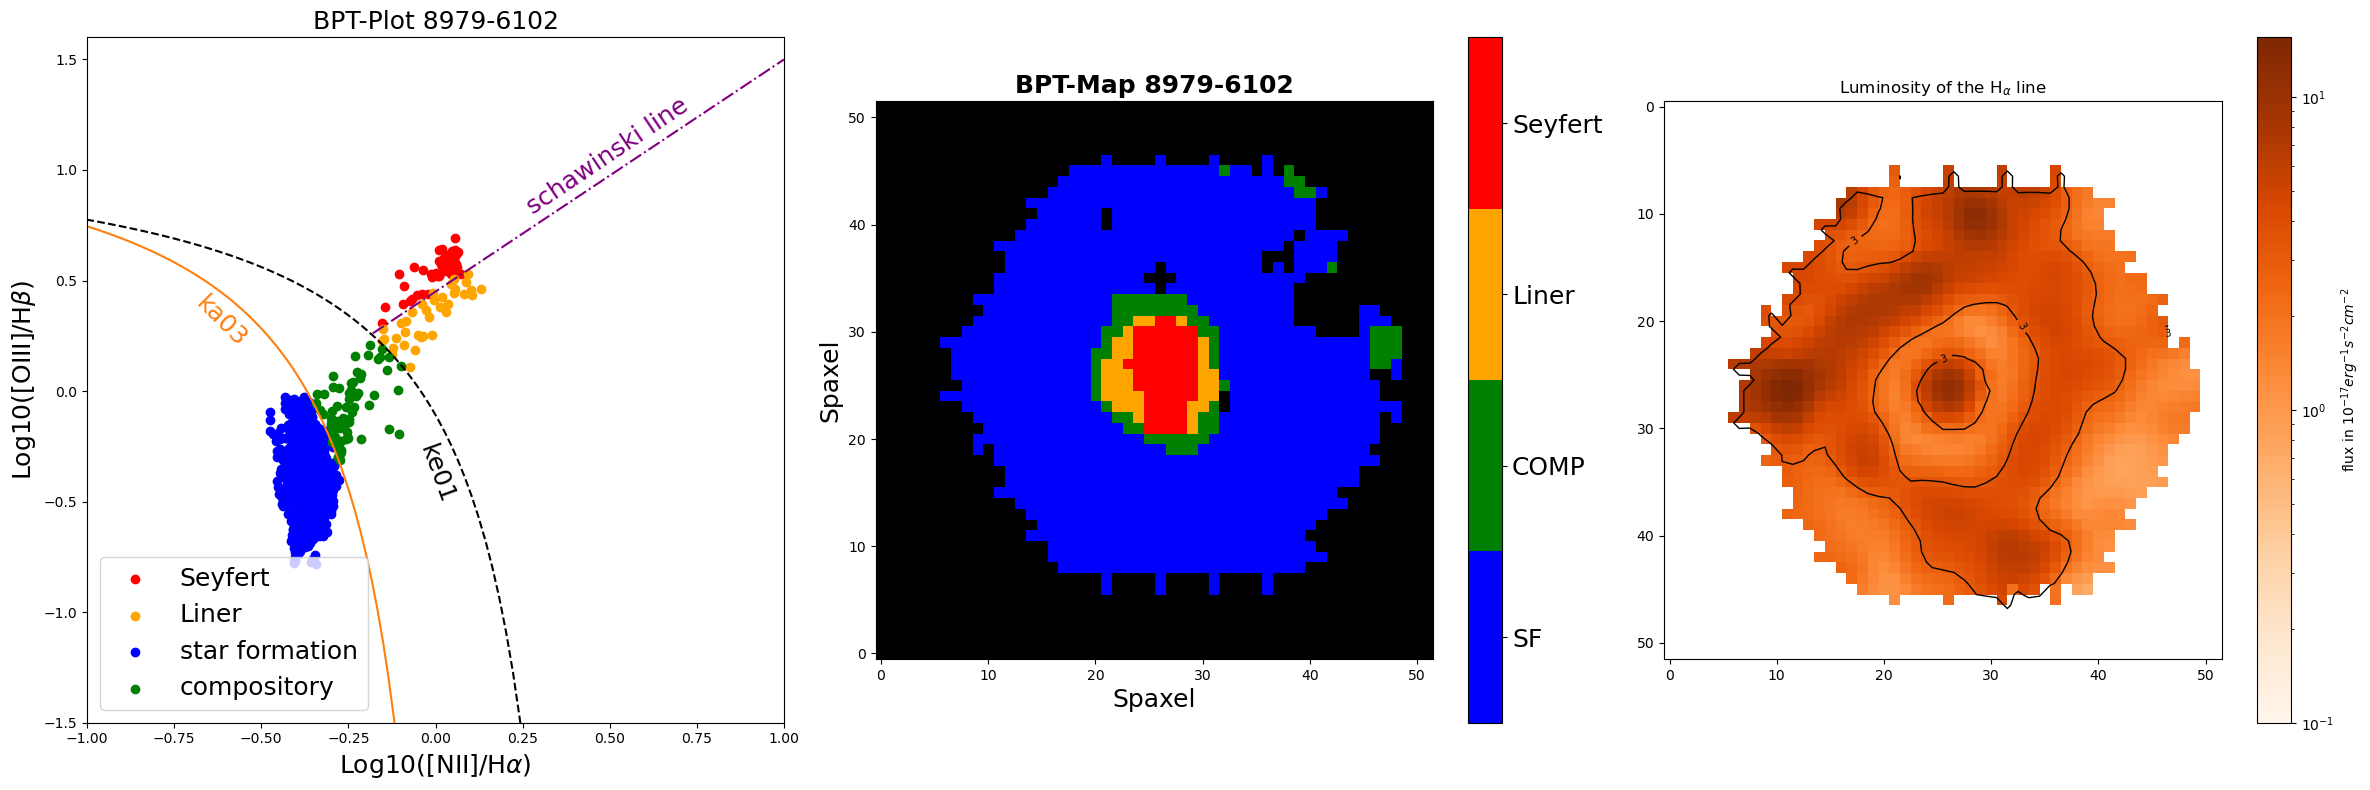

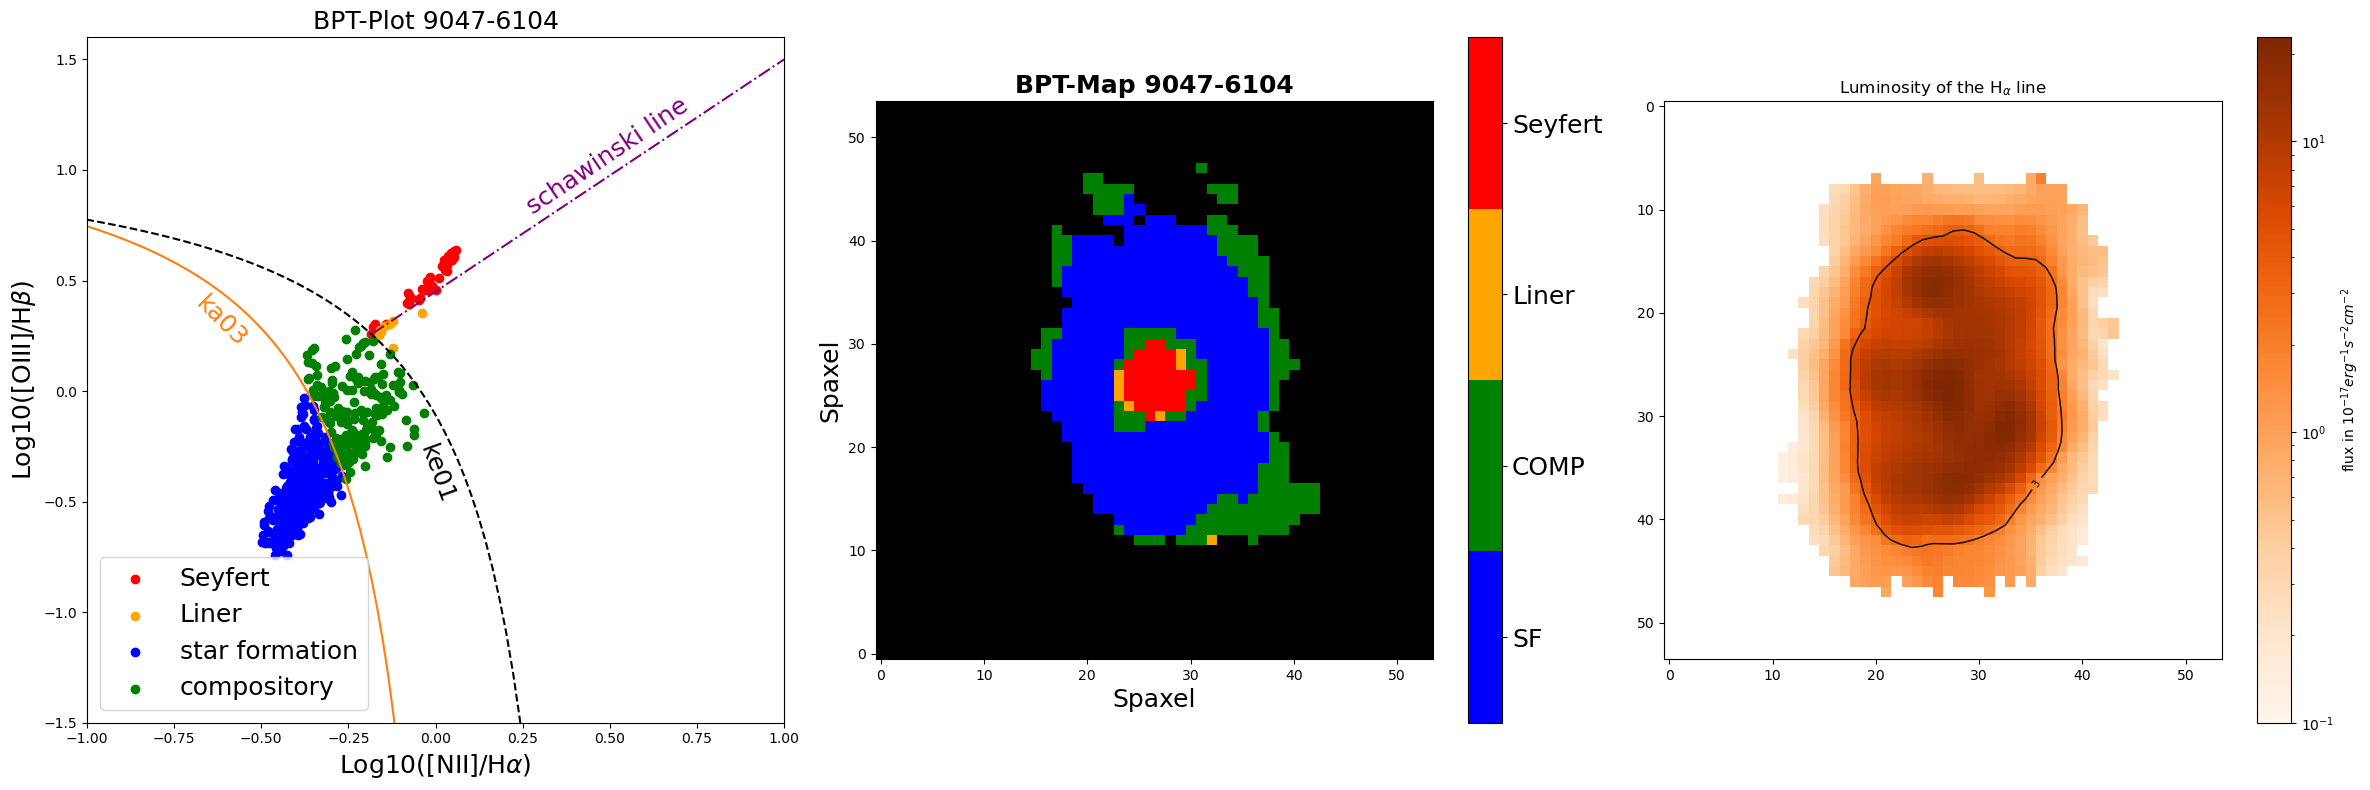

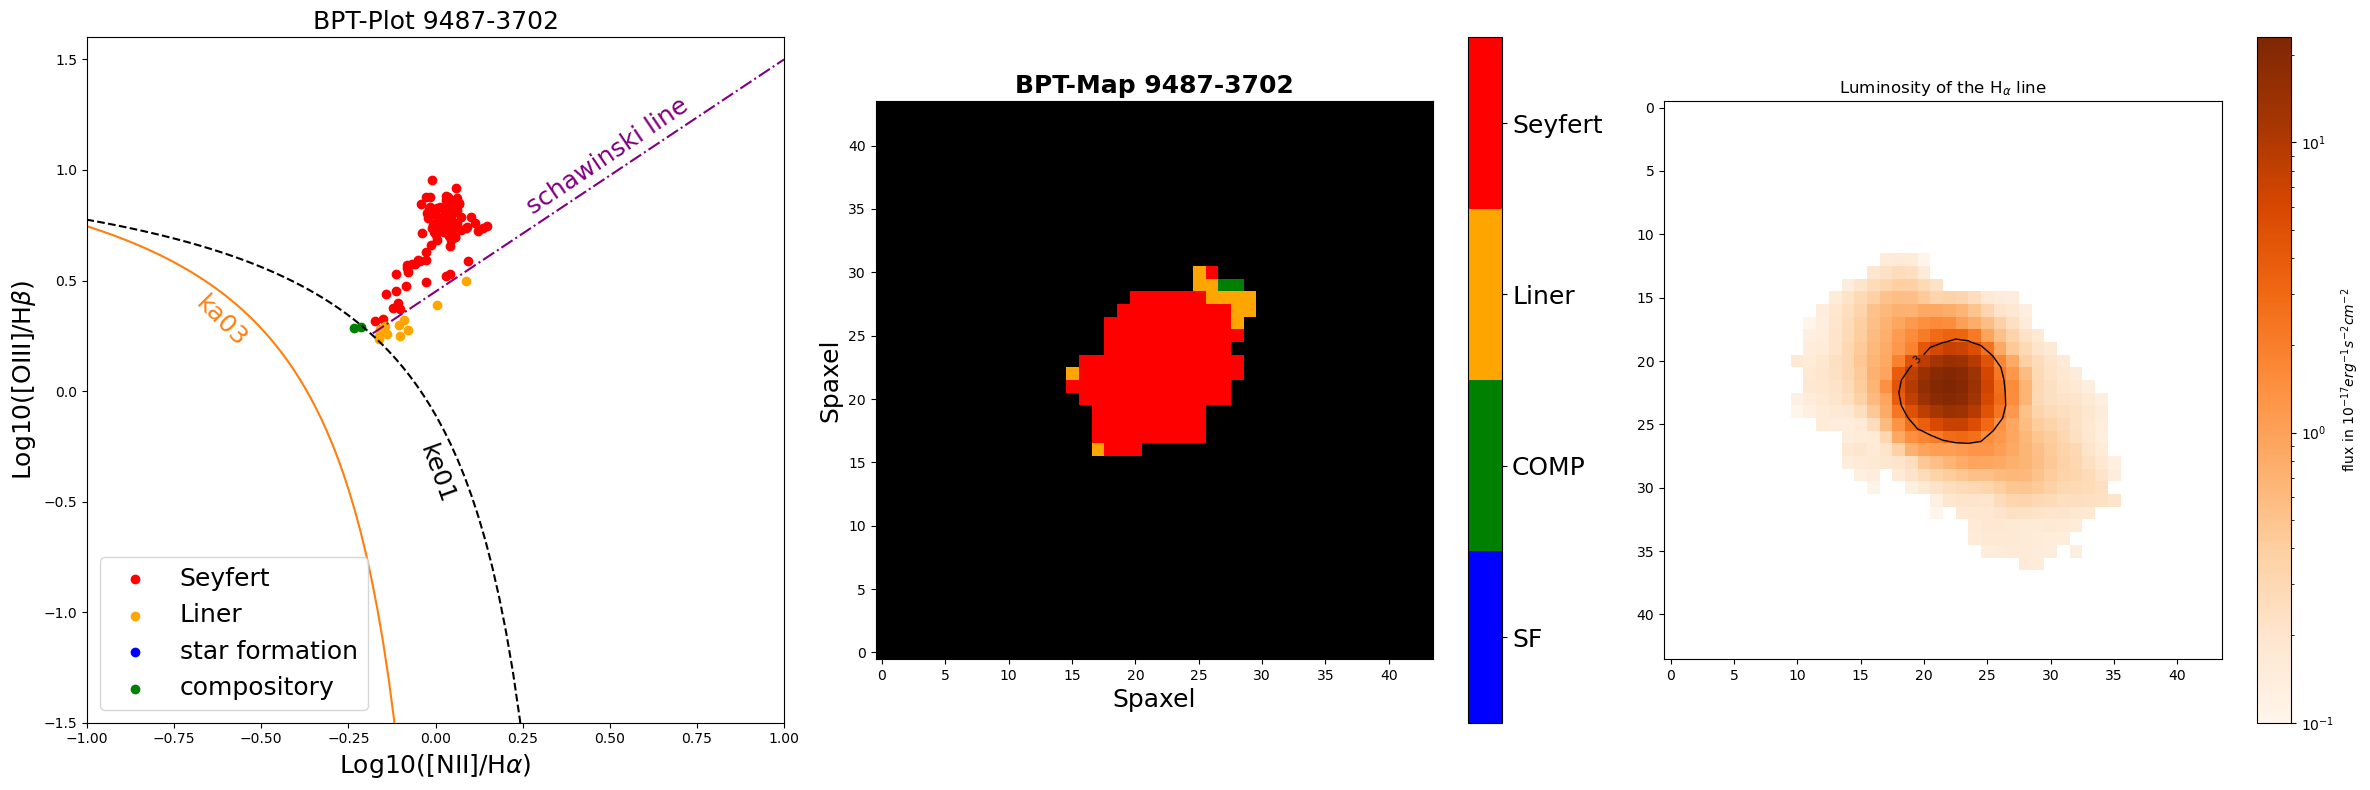

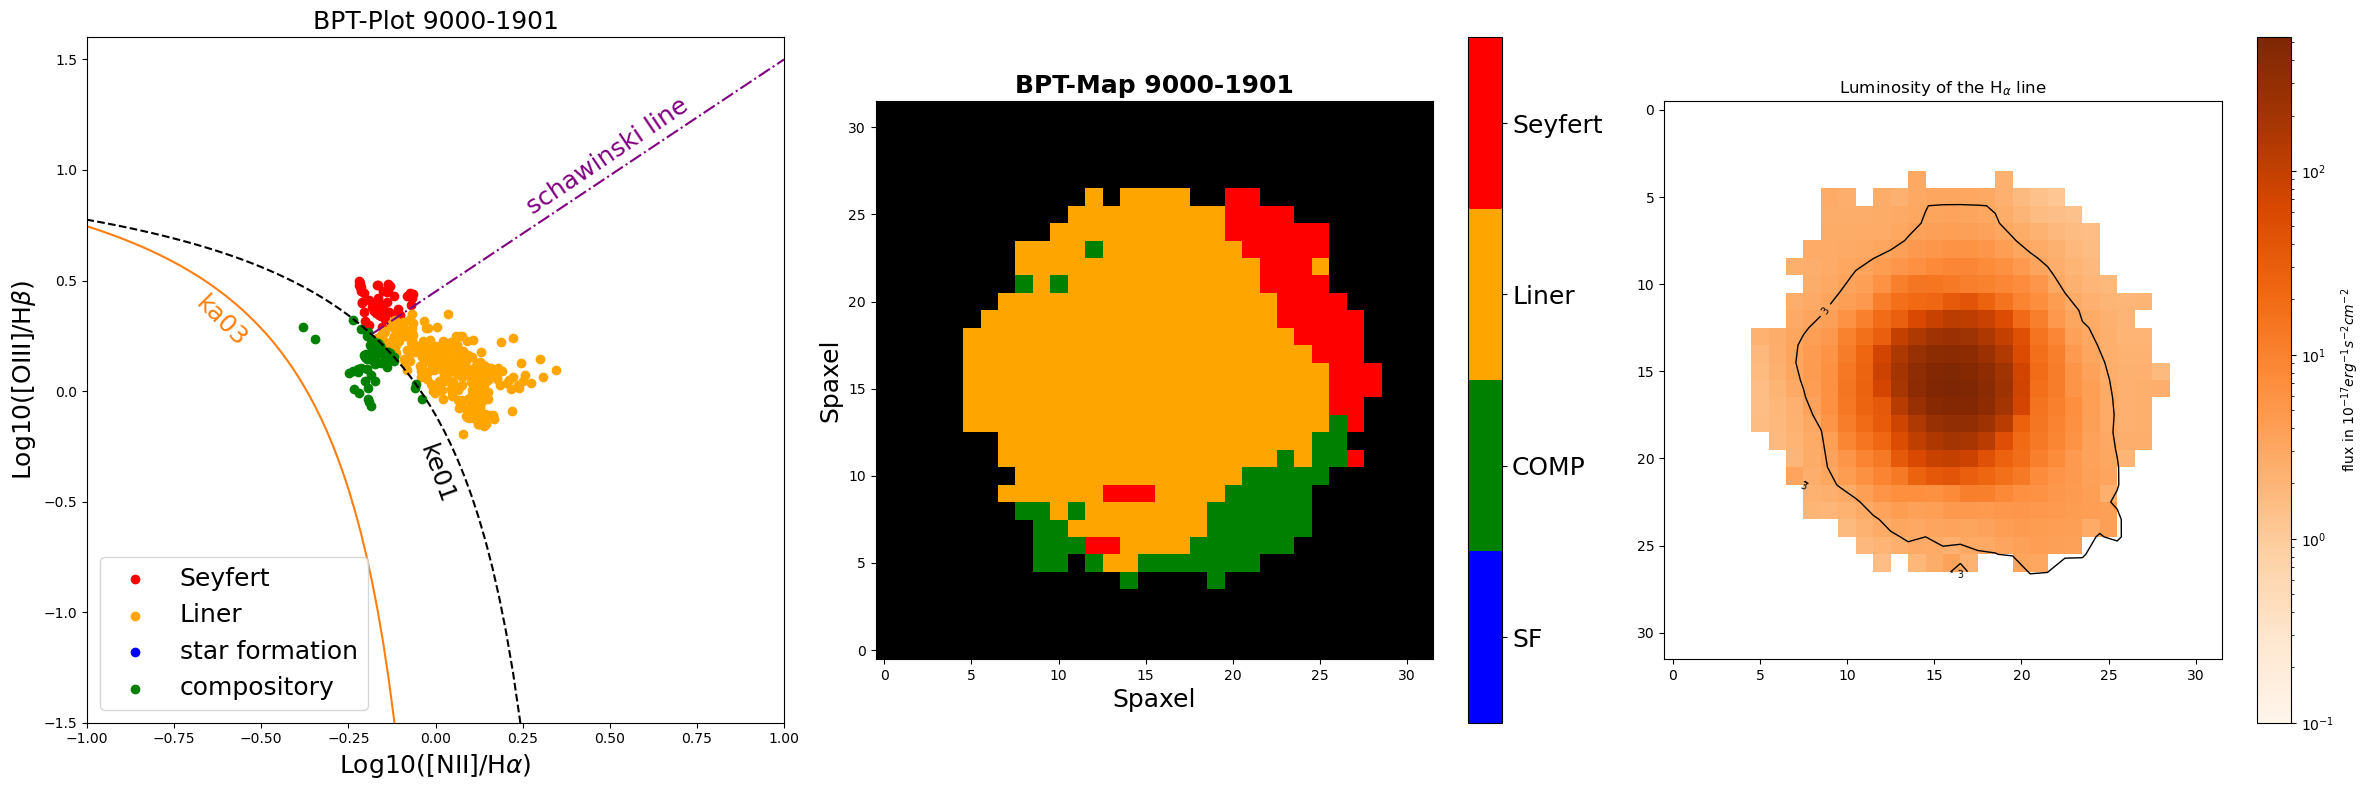

In [30]:
BPT_Plot_OIII(str(marco_but_not_me[0]))
BPT_Plot_OIII(str(marco_but_not_me[1]))
BPT_Plot_OIII(str(marco_but_not_me[2]))
BPT_Plot_OIII(str(me_but_not_marco[0]))

I don't see a reason, why any of these galaxies here scchouldn't be a AGN

In [16]:
use_AGN = True
strict_AGN = False
mode = 'S2'
use_composite = True
use_HaEW = True
is_debug = False
data_string = "{} {} {} {} {} {} {} {} {} \n" 
data_items = ["plateifu", "ra", "dec", "z", "psf","BPT_x","BPT_y", "EW_Ha", "is_limit"]

targets = marco_but_not_me + me_but_not_marco

mangaid_list = []
error_list = []
abandon_list = []
nodata_list = []
agn_list = []
agn_binaries = []
f_agn = open('data/AGNs_control-'+today+'.dat', 'w')
f_agn.write("# the selected AGNs\n")
f_agn.write(data_string.format(*data_items))

abandon_list = []
# exclude galaxies, either not AGN or not (AGN + composite)
f_exclude = open('data/AGNs-exclude-'+today+'.dat', 'w')
f_exclude.write("# the excluded, use_AGN is {}, use_composite is {}\n".format(use_AGN, use_composite))
f_exclude.write(data_string.format(*data_items))

# used for counting
ct = 1
total = len(targets)

# loop through all the MPL6
for glx, plateifu in zip(range(len(targets)), targets):
    if is_debug:
        print('plateifu: {}'.format(plateifu))
    try:
        g = Maps(plateifu)
        psf = np.float(g.header['GFWHM'])
        z = np.float(g.dapall['z'])
        ra = g.dapall['ifura']
        dec = g.dapall['ifudec']
    except Exception as ex:
        if is_debug:
            print("{}: {}".format(plateifu, ex))
        error_list.append(plateifu)
        ct += 1
        continue
    if z < 0:
        continue
    mangaid = plateifu # g.mangaid
    # deal with repeated observation
    if mangaid in mangaid_list:
        abandon_list.append(plateifu)
        ct += 1
        if is_debug:
            print(plateifu, 'is repeatedly oberserved')
        continue
    
    ha   = g['emline_gflux_ha_6564']
    hb   = g['emline_gflux_hb_4862']
    oiii = g['emline_gflux_oiii_5008']
    nii  = g['emline_gflux_nii_6585']

    ha [ha.snr < 5] = 0
    hb [hb.snr < 5] = 0
    oiii [oiii.snr < 5] = 0
    nii [nii.snr < 5] = 0   


    log_oiii_hb = np.log10(oiii.value / hb.value)
    log_nii_ha = np.log10(nii.value / ha.value) 

    x1 = np.linspace(-1.5, 0.46, 100)
    x2 = np.linspace(-1.5, 0.09, 100)
    x3 = np.linspace(-0.18, 1, 100)

    def ke01(x):
            return(0.61/(x-0.47)+1.19)
    def ka03(x):
        return(0.61/(x-0.1)+1.3)    
    def schawinski_line(x):
        return(1.05*x+0.45)

    inv_bool  = np.ones(ha.shape, dtype='bool')
    agn_bool  = np.zeros(ha.shape, dtype='bool') 
    sf_bool   = np.zeros(ha.shape, dtype='bool')
    comp_bool = np.zeros(ha.shape, dtype='bool')

    inv_bool  [np.where(np.isnan(log_oiii_hb))] = False
    inv_bool  [np.where(np.isnan(log_nii_ha))] = False
    inv_bool  [np.where(np.isfinite(log_oiii_hb) == False)] = False
    inv_bool  [np.where(np.isfinite(log_nii_ha) == False)] = False

    agn_bool  [np.where((log_oiii_hb >=  ke01(log_nii_ha)) & inv_bool) and np.where((log_nii_ha > 0.47) & inv_bool)] = True
    agn_bool  [np.where((log_oiii_hb >=  ke01(log_nii_ha)) & inv_bool)] = True
    comp_bool [np.where((log_oiii_hb >=  ka03(log_nii_ha)) & (log_oiii_hb <=  ke01(log_nii_ha)) & inv_bool
                     & (log_nii_ha <= 0.47))] = True
    comp_bool [np.where((log_oiii_hb <=  ke01(log_nii_ha)) & (0.47 >= log_nii_ha) &
                        ( log_nii_ha >= 0.1) & inv_bool)] = True
    sf_bool   [np.where((log_oiii_hb <  ka03(log_nii_ha)) & (log_oiii_hb <  ke01(log_nii_ha)) & (log_nii_ha < 0.1)
                        & inv_bool)] = True

    agn_ratio = np.sum(agn_bool)/np.sum(inv_bool)

    agn = agn_bool
    cp = comp_bool
    sf = sf_bool
    if strict_AGN:
        agn = sy
    if use_composite:
        agn = agn | cp
    
    r, phi = g['spx_ellcoo_elliptical_radius'].value, g['spx_ellcoo_elliptical_azimuth'].value
    inner3deg = sector_binning(r, phi, r_max=3.0)
    innerpsf = sector_binning(r, phi, r_max=psf/2)
    ewHa_region = g['emline_gflux_ha_6564'].value > 3
    if use_HaEW:
        select_region = agn & inner3deg & ewHa_region
    else:
        select_region = agn & inner3deg

    agn_frac = np.sum(select_region)/np.sum(inner3deg)

    
    if agn_frac > 0.66:
        agn_list.append(plateifu)
        rmax = np.max(r[select_region])
        
        BPT_X =  np.ma.median( log_nii_ha [select_region] )
        BPT_Y =  np.ma.median( log_oiii_hb [select_region] )
        
        if rmax > psf/2: 
            is_limit = 0
        else:
            is_limit = 1 #upper limit, unresolved
        f_agn.write(data_string.format(
                plateifu, ra, dec, z, psf, BPT_X, BPT_Y, 
                np.ma.median(g['emline_gflux_ha_6564'].value [select_region]), is_limit))
    else:
        BPT_X =  np.ma.median( log_nii_ha [inner3deg] )
        BPT_Y =  np.ma.median( log_oiii_hb [inner3deg] )

        if np.ma.is_masked(BPT_X) or np.ma.is_masked(BPT_Y):
            nodata_list.append(plateifu)
            if is_debug:
                print(plateifu, 'have no data in BPT diagram')
            ct += 1
            continue
        f_exclude.write(data_string.format(
                plateifu, ra, dec, z, psf, BPT_X, BPT_Y, 
                np.ma.median(g['emline_gflux_ha_6564'].value [inner3deg]),
                0))
    if not is_debug: 
        processBar(total, ct)
        ct += 1

print("\n{} agns have found. Besides, {} in binaries, but {} errors, {} have no BPT data".format(
      len(agn_list), len(agn_binaries), len(error_list), len(nodata_list)))
print("AGNs Write into {}".format(f_agn.name))
print("Others exclude AGNs Write into {}".format(f_exclude.name))
f_agn.close()
f_exclude.close()

[########################################] 100% 

2 agns have found. Besides, 0 in binaries, but 0 errors, 0 have no BPT data
AGNs Write into data/AGNs_control-20.12.2022.dat
Others exclude AGNs Write into data/AGNs-exclude-20.12.2022.dat
